In [49]:
install.packages(c("sf", "dplyr", "units"))
library(sf)
library(dplyr)
library(units)


Warning message:
"正在使用'sf', 'dplyr', 'units'这个程序包，因此不会被安装"


In [ ]:
# function to compute the accessibility index
compute_accessibility_index <- function(local_areas, points_of_interest, population_data) {
  local_areas <- st_transform(local_areas, crs = 4326)
  points_of_interest <- st_transform(points_of_interest, crs = 4326)
  
  local_areas <- left_join(local_areas, population_data, by = "name")
  
  areas_union <- st_union(local_areas)
  points_of_interest <- st_intersection(points_of_interest, areas_union)
  
  area_centroids <- st_centroid(local_areas)
  
  # Calculate average distance from each local area to points of interest
  distance_matrix <- st_distance(area_centroids, points_of_interest)
  distance_matrix_km <- set_units(distance_matrix, "km")
  avg_distance_km <- apply(distance_matrix_km, 1, mean, na.rm = TRUE)
  local_areas$avg_distance_km <- avg_distance_km
  
  # Calculate points of interest density
  local_areas$area_km2 <- st_area(local_areas) %>% set_units("km^2") %>% set_units(NULL)

  points_in_areas <- st_join(points_of_interest, local_areas, join = st_within)
  poi_counts <- points_in_areas %>%
    st_set_geometry(NULL) %>%
    group_by_at("name") %>%
    summarise(poi_count = n())
  
  local_areas <- left_join(local_areas, poi_counts, by = "name")
  local_areas$poi_count[is.na(local_areas$poi_count)] <- 0

  local_areas$poi_density <- local_areas$poi_count / local_areas$area_km2
  
  # Calculate points per 10,000 population
  local_areas$poi_per_10k_pop <- (local_areas$poi_count / local_areas$population) * 10000
  
  # Normalize the values ([0, 1] range)
  normalize <- function(x) {
    return((x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE)))
  }
  
  local_areas$avg_distance_norm <- normalize(avg_distance_km)
  local_areas$poi_density_norm <- normalize(local_areas$poi_density)
  local_areas$poi_per_10k_pop_norm <- normalize(local_areas$poi_per_10k_pop)
  
  local_areas$avg_distance_norm_inv <- 1 - local_areas$avg_distance_norm
  
  local_areas$accessibility_index <- (local_areas$avg_distance_norm_inv +
                                      local_areas$poi_density_norm +
                                      local_areas$poi_per_10k_pop_norm) / 3
  
  
  return(local_areas)
}


Reading layer `Stops' from data source 
  `D:\ME 2024 UBC\ECON 326\econ326\transit_data\Stops.shp' using driver `ESRI Shapefile'
Simple feature collection with 8785 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -123.4231 ymin: 49.00439 xmax: -122.3029 ymax: 49.47356
Geodetic CRS:  WGS 84
Reading layer `local-area-boundary' from data source 
  `D:\ME 2024 UBC\ECON 326\econ326\transit_data\local-area-boundary.geojson' 
  using driver `GeoJSON'
Simple feature collection with 22 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -123.2248 ymin: 49.19894 xmax: -123.0232 ymax: 49.29581
Geodetic CRS:  WGS 84


Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"st_centroid assumes attributes are constant over geometries"


Simple feature collection with 22 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -123.2248 ymin: 49.19894 xmax: -123.0232 ymax: 49.29581
Geodetic CRS:  WGS 84
First 10 features:
                  name avg_distance_km poi_density poi_per_10k_pop
1             Downtown        4.846520   40.532732        30.46913
2     Hastings-Sunrise        6.217951   12.993115        31.23644
3           Kerrisdale        6.209519    6.977132        32.91592
4              Marpole        6.093279   11.688837        28.61815
5             Oakridge        4.882206   15.197184        46.81504
6           Riley Park        3.982990   14.228318        31.03525
7         South Cambie        4.162934   16.120887        43.91468
8          Shaughnessy        4.616570   12.753219        67.61566
9  Victoria-Fraserview        5.531697   17.130517        30.25913
10   Dunbar-Southlands        7.184482    7.286453        30.80513
   accessibility_index                       geo

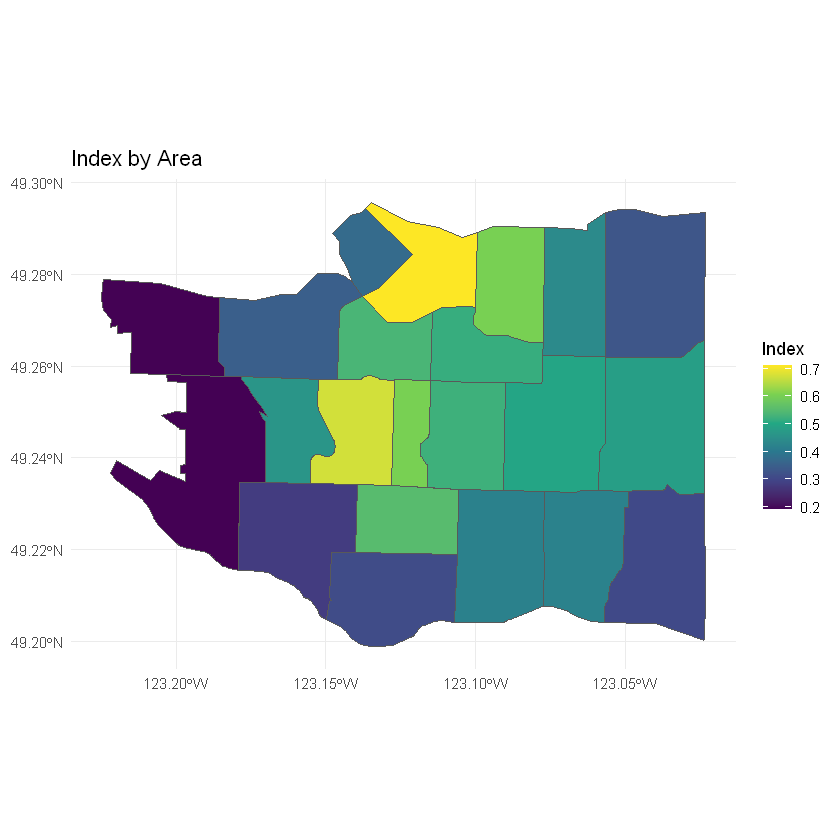

In [ ]:
bus_stops <- st_read("./transit_data/Stops.shp")

local_areas <- st_read("./transit_data/local-area-boundary.geojson")

# Population data from 2016 Census
population_data <- data.frame(
  name = c(
    "Arbutus Ridge", "Downtown", "Dunbar-Southlands", "Fairview",
    "Grandview-Woodland", "Hastings-Sunrise",
    "Kensington-Cedar Cottage", "Kerrisdale",
    "Killarney", "Kitsilano", "Marpole", "Mount Pleasant", "Oakridge",
    "Renfrew-Collingwood", "Riley Park", "Shaughnessy", "South Cambie",
    "Strathcona", "Sunset",
    "Victoria-Fraserview", "West End",
    "West Point Grey"
  ),
  population = c(
    15295, 62030, 21425, 33620,
    29175, 34575, 49325, 13975,
    29325, 43045, 24460, 32955, 13030,
    51530, 22555, 8430, 7970,
    12585, 36500, 31065, 47200, 13065
  )
)

# compute overall index
local_areas_with_index <- compute_accessibility_index(
  local_areas = local_areas,
  points_of_interest = bus_stops,
  population_data = population_data
)

library(ggplot2)
ggplot(data = local_areas_with_index) +
  geom_sf(aes(fill = accessibility_index)) +
  scale_fill_viridis_c() +
  theme_minimal() +
  labs(title = "Index by Area", fill = "Index")

# Export results as GeoJSON file
print(local_areas_with_index %>% select(name, avg_distance_km, poi_density, poi_per_10k_pop, accessibility_index))
st_write(local_areas_with_index, "stops_index.geojson", delete_dsn = TRUE)
